In [25]:
!pip install graphlearning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphlearning: filename=graphlearning-1.4.3-cp310-cp310-linux_x86_64.whl size=159184 sha256=cf5808db7ab9656b669f04714d9f81c93dc365ae957a39c32c5c02dca0237143
  Stored in directory: /root/.cache/pip/wheels/86/65/ac/9913720021b74276c69eb306d4e146911649a0ead5a8cbef65
Successfully built graphlearning


In [173]:
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import fsolve
import scipy
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn import manifold
import scipy.misc

import graphlearning as gl

import matplotlib.pyplot as plt

In [3]:
def noisyswissroll(RES=100, noise=0.00, noise_type = 'normal'):
    """swiss roll on a grid """
    theta0 = 3*np.pi/2
    nturns = 2
    rmax = 2*1e-2
    sideL1 = integrate.quad(lambda x: rmax*np.sqrt(1+x**2), theta0, theta0*(1+nturns))[0]
    sideL2 = 1/sideL1
    RESt = int(np.ceil(sideL1*RES+1))
    tdistv = np.linspace(0,sideL1,RESt)
    tv = []
    for tdist in tdistv.tolist():
        tt = fsolve(lambda x: (0.5*rmax*(x*np.sqrt(1+x**2)+np.arcsinh(x)))-\
                                0.5*rmax*(theta0*np.sqrt(1+theta0**2)+np.arcsinh(theta0))-\
                                tdist,theta0*(1+nturns/2))
        tv.append(tt)
    tv = np.array(tv)
    RESh = int(np.ceil(sideL2*RES+1))
    heightv = np.linspace(0,sideL2,RESh)[:,np.newaxis]
    heightv = np.tile(heightv,[RESt,1])
    heightv = heightv.flatten('F')[:,np.newaxis]
    tv = np.repeat(tv,RESh)[:,np.newaxis]
    X=np.concatenate([rmax*tv*np.cos(tv), heightv, rmax*tv*np.sin(tv)], axis=1)
    np.random.seed(42)
    if noise_type == 'normal':
        X = X+noise*np.random.normal(0,1,[X.shape[0],3])
    elif noise_type == 'uniform':
        X = X+noise*np.random.uniform(0,1,[X.shape[0],3])
    labelsMat = np.concatenate([tv, X[:,[1]]], axis=1)
    print('X.shape = ', X.shape)
    return X, labelsMat, tv

In [10]:
X, labels, tv = noisyswissroll()
n = labels.shape[0]
X.shape, labels.shape

X.shape =  (10260, 3)


((10260, 3), (10260, 2))

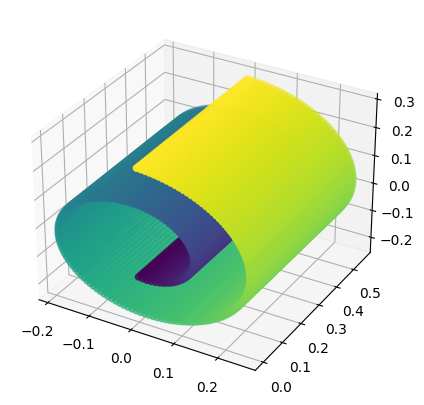

In [19]:
"""swiss roll observations """
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=tv)
plt.show()

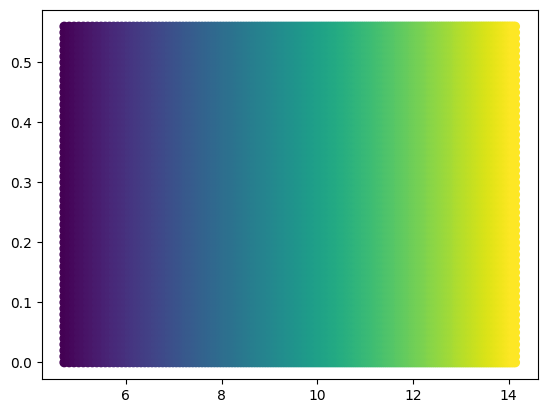

In [20]:
"""swiss roll ground truth """

plt.scatter(labels[:,0], labels[:,1], c=tv)

In [185]:
l = labels - labels.mean()
Cl = l.T@l
D, V = scipy.linalg.eigh(Cl)
Clsqrt = (V * np.sqrt(D)) @ V.T
Clinvsqrt = np.linalg.inv(Clsqrt)
l = l@Clinvsqrt

Text(0.5, 1.0, 'LLE Embedding of Swiss Roll Error: 2.35')

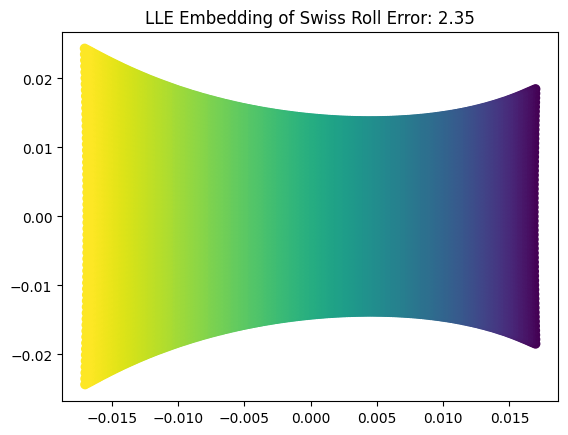

In [187]:
"""sklearn tsne """
sr_lle, sr_err = manifold.locally_linear_embedding(X, n_neighbors=12, n_components=2)

plt.scatter(sr_lle[:, 0], sr_lle[:, 1], c=tv)
plt.title(f"LLE Embedding of Swiss Roll Error: {np.linalg.norm(l - sr_lle):.2f}")

In [ ]:
"""sklearn spectral embedding (takes a long time) """
#embedding = manifold.SpectralEmbedding(n_components=2)
#sr_se = embedding.fit_transform(X)

#plt.scatter(sr_se[:, 0], sr_se[:, 1], c=tv)
#plt.title("LLE Embedding of Swiss Roll")

In [190]:
"""semi-supervised procrustes """
# uniformly randomly sample points to label
train_ind = np.random.choice(n, 1000, replace=False)
train_ind = np.sort(train_ind)
F = train_labels = labels[train_ind]
F = F - F.mean(0)

Cf = F.T@F
D, V = scipy.linalg.eigh(Cf)
Cfsqrt = (V * np.sqrt(D)) @ V.T
Cfinvsqrt = np.linalg.inv(Cfsqrt)
F = F@Cfinvsqrt

idx = np.ones(n, dtype=bool)
idx[train_ind] = False

W = gl.weightmatrix.knn(X, k=10, kernel='distance')
G = gl.graph(W)
L = G.laplacian(normalization='normalized')

Ltilde = L[idx][:, idx]
B = L[:,train_ind]*F
B = -B[idx,:]

# calculate dirichlet eigenvectors
_vals, _vecs = gl.utils.dirichlet_eigenvectors(L, [], 5)
vecs = _vecs[idx,1:3]

# calculate Q transform from prop
XtB = vecs.T@B
U, s, Vh = np.linalg.svd(XtB)
Q = U@Vh
vecs = vecs@Q

emb = np.zeros((n,2))
emb[idx] = 2**2*vecs
emb[~idx] = F

Text(0.5, 1.0, 'Procrustes Embedding of Swiss Roll Error: 5.10')

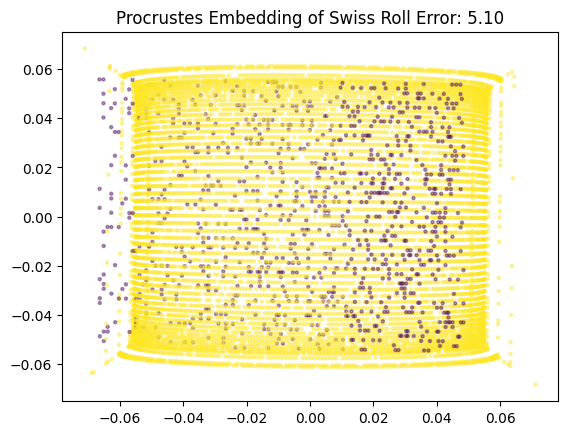

In [188]:
plt.scatter(emb[:, 0], emb[:, 1], c=idx, alpha=0.4, s=5)
plt.title(f"Procrustes Embedding of Swiss Roll Error: {np.linalg.norm(l - emb):.2f}")

Text(0.5, 1.0, 'Procrustes Embedding of Swiss Roll Error: 5.10')

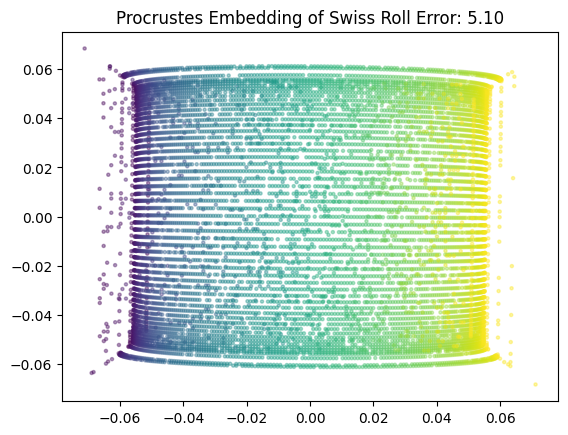

In [189]:
plt.scatter(emb[:, 0], emb[:, 1], c=tv, alpha=0.4, s=5)
plt.title(f"Procrustes Embedding of Swiss Roll Error: {np.linalg.norm(l - emb):.2f}")